# Analysis code

This notebook uses data downloaded in the `download_extract_data` notebook to predict $CV[S_0]$ for the two study sites, Elder Creek and Dry Creek. $CV[ET_{dry}]$ is then calculated from remotely sensed data and used to infer $S_{max}$ at the sites. 

In [1]:
%matplotlib inline
import os
import sys
from os.path import dirname
from matplotlib import pyplot as plt
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
import matplotlib.dates as mdates
import glob
import datetime
import multiprocessing as mp

# Helper functions

In [2]:
# Rainfall interception function
def intercept_rain_daily(ppt, interception_depth):
    return ppt.apply(lambda val: np.max([val-interception_depth, 0]))


def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges


def get_precip_stats(ppt, clustered=True, interception_depth=0, doystart=275, doyend=140, loud=True):
    ppt = intercept_rain_daily(ppt, interception_depth)
    if doystart>doyend:
        wet_season = ppt[(ppt.index.dayofyear>=doystart)|(ppt.index.dayofyear<=doyend)].ffill().values
    else: 
        wet_season = ppt[(ppt.index.month>=doystart)&(ppt.index.month<=doyend)].ffill().values
    
    # Normal rainfall stats
    lam = len(wet_season[wet_season>0])/float(len(wet_season))
    alpha = np.mean(wet_season[wet_season>0])
    
    # Calculate clustered stats
    runs = zero_runs(wet_season<=0)
    lam_clustered = len(runs)/float(len(wet_season))
    alpha_clustered = np.nanmean(np.array( [np.sum(wet_season[idx[0]:idx[1]]) for idx in runs]))
    if clustered: 
        lam = lam_clustered
        alpha = alpha_clustered
    if loud:
        print('Rainfall frequency = %.3f per day, mean event depth = %.f mm'%(lam, alpha))
    return lam, alpha


def run_chunk_nondimensional(arguments):
    gam, etalam, taumax, dtau, num_sims = arguments        
    tau = np.linspace(0,taumax,int(np.ceil(taumax/dtau)))
    X = np.zeros((num_sims, len(tau)))
    for num in range(num_sims):
        rainfall = np.array([np.random.exponential(1/gam) if np.random.uniform() > np.exp(-dtau) else 0.0 for i in range(len(tau))])
        x = np.zeros_like(rainfall)
    for idx in range(len(rainfall)-1):
        dx = rainfall[idx] - etalam*x[idx]*dtau
        x[idx+1] = x[idx] + dx
        x[idx+1] = np.min([x[idx+1],1])
    X[num,:]=x
    CV = np.std(X[:,-1])/np.mean(X[:,-1])
    return CV

def run_chunk_wetseason(arguments):
    lam, smax, alpha, dt, tw, pet, num_sims = arguments        
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))
    S = np.zeros((num_sims, len(t)))
    np.random.seed()
    for num in range(num_sims): 
        rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
        storage = np.zeros_like(rainfall)
        for idx in range(len(rainfall)-1):
            dstorage = rainfall[idx] - pet*storage[idx]/smax*dt
            storage[idx+1] = storage[idx] + dstorage
            storage[idx+1] = np.min([storage[idx+1], smax])
        S[num,:] = storage
    return S

# Determine $T_w$

Compute composite wet season. Find $C_{2.5}$ and $C_{97.5}$.

Length of wet season is 214 days


/opt/anaconda3/envs/py3k/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


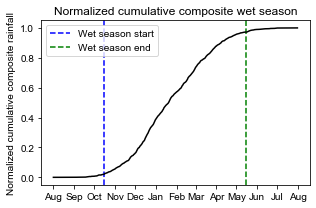

In [3]:
# ppt = pd.read_csv('../data/elder_ppt.csv', parse_dates=True, index_col=0).ppt*1000
# ppt = ppt.resample('D').mean()

prism_ppt = pd.read_csv('../data/elder_dry_prism_ppt.csv', header=[0,1],parse_dates=True, index_col=0)
ppt = prism_ppt[('ppt', 'Elder Creek')]

middry = 210
ppt_dowy = pd.DataFrame(ppt.values, index=ppt.index, columns=['ppt'])
ppt_dowy['dowy'] = ppt_dowy.index.dayofyear - middry
ppt_dowy.loc[ppt_dowy.dowy<=0, 'dowy'] += 365
pptdowy = ppt_dowy.groupby('dowy').sum()
maxval = pptdowy.sum()
normalized = pptdowy.cumsum()/maxval
percentage = 2.5
wetstart = pd.to_timedelta(middry + np.where(normalized>percentage/100.0)[0][0],unit='day') + pd.to_datetime('2018-01-01')
wetend = pd.to_timedelta(middry + np.where(normalized>(100-percentage)/100.0)[0][0],unit='day') + pd.to_datetime('2018-01-01')
doystart = wetstart.dayofyear
doyend = wetend.dayofyear

# Wet season start and end months
tw = len(pd.date_range(wetstart, wetend))

# PET data from download_extract_data notebook
pet_df = pd.read_csv('../data/elder_dry_pet.csv', parse_dates=True, index_col=0)
pet_wet = pet_df.loc[(pet_df.index.dayofyear>=doystart)|(pet_df.index.dayofyear<=doyend)].mean()
pet = float(pet_wet['Elder Creek'])
print('Length of wet season is %d days'%tw)

oneyear = pd.date_range('2018-08-01', '2019-07-31')
plt.figure(figsize=(4.5,3))
plt.plot(oneyear, normalized,'k')
plt.title('Normalized cumulative composite wet season')
plt.ylabel('Normalized cumulative composite rainfall')
plt.vlines(wetstart, -0.05,1.05,colors='b', linestyles='dashed', label='Wet season start')
plt.vlines(wetend, -0.05,1.05,colors='g', linestyles='dashed', label='Wet season end')

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.legend()
plt.ylim([-0.05,1.05])
plt.tight_layout()
plt.savefig('../plots/wet_season_start_end.pdf')

In [4]:
print('Calculated with ERCZO rainfall data...')
angelo_ppt = pd.read_csv('../data/elder_ppt.csv', parse_dates=True, index_col=0).ppt*1000
angelo_ppt = angelo_ppt.resample('D').mean()
lam_angelo, alpha_angelo = get_precip_stats(angelo_ppt, interception_depth=4.0, clustered=True, doystart=doystart, doyend=doyend,loud=True)
print('\n')

prism_ppt = pd.read_csv('../data/elder_dry_prism_ppt.csv', header=[0,1],parse_dates=True, index_col=0)
print('Calculated with PRISM...')
prism_lam, prism_alpha = get_precip_stats(prism_ppt[('ppt', 'Elder Creek')], clustered=True, interception_depth=4.0, doystart=doystart, doyend=doyend,loud=True)

# set lam/alpha to those from PRISM
lam,alpha = prism_lam, prism_alpha

Calculated with ERCZO rainfall data...
Rainfall frequency = 0.119 per day, mean event depth = 65 mm


Calculated with PRISM...
Rainfall frequency = 0.111 per day, mean event depth = 75 mm


# Load and calculate CV[${ET}_{dry}$]

In [8]:
ets = pd.read_csv('../data/elder_dry_et.csv', index_col=0, parse_dates=True)
drystart = 6
dryend = 9
drys = ets.loc[(ets.index.month>=drystart)&(ets.index.month<=dryend)]
dry_ets = drys.groupby(drys.index.year).sum()
etcvs = dry_ets.std()/dry_ets.mean()

# Run Monte Carlo simulations to setup inversion

*DO NOT RUN UNLESS CHANGING PARAMETERS*

Using rainfall statistics ($\lambda$ and $\alpha$, wet season length ($T_{wet}$), and average wet season potential evapotranspiration (PET), we can solve the stochastic model for the coefficient of variation of $S_0$.

Do not run this script unless necessary; it takes several hours to complete on an average laptop computer. Calculated CV data is already stored in the `../data` folder

Running 15000 simulations for 50 parameter sets across 4 cores


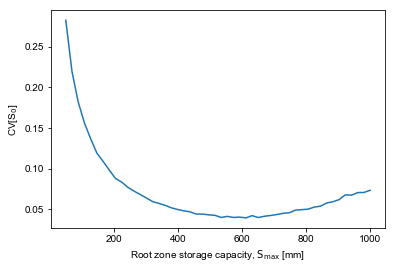

In [6]:
# SETUP PARAMETERS
num_sims = 15000
dt = 0.1
smaxlower = 50
smaxupper = 1000
numS = 50
Smax = np.linspace(smaxlower, smaxupper, numS)
args = [(lam, Smax[i], alpha, dt, tw, pet, num_sims) for i in range(len(Smax))]

# GET CORES AND RUN MODEL
num_cores = mp.cpu_count()
print('Running %d simulations for %d parameter sets across %d cores'%(num_sims,len(args),num_cores ))
pool = mp.Pool(processes=num_cores)
F = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in F]

# PLOT AND SAVE
f,ax = plt.subplots(1, figsize=(6,4))
ax.plot(Smax, CV)
ax.set_xlabel('Root zone storage capacity, $\mathrm{S_{max}}$ [mm]')
ax.set_ylabel('CV[S$_0$]')
np.save('../data/cvs_dry_elder_%d_%d_%d.npy'%(smaxlower, smaxupper, numS), CV)

# Monte Carlo for exploring different climatic regimes

*DO NOT RUN UNLESS CHANGING PARAMETERS*

How do changes in $\lambda$ and $\alpha$ impact $CV[S_0]$ as a function of $S_{max}$?

Do not run this script unless necessary; it takes several hours to complete on an average laptop computer. Calculated CV data is already stored in the `../data` folder.

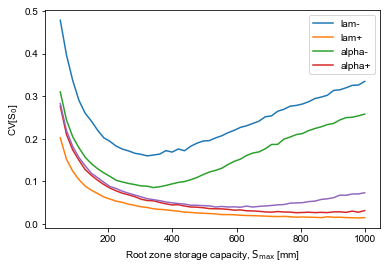

In [14]:
# SETUP PARAMETERS
num_sims = 10000
dt = 0.1
smaxlower = 50
smaxupper = 1000
numS = 50
Smax = np.linspace(smaxlower, smaxupper, numS)
f,ax = plt.subplots(1, figsize=(6,4))

lamtemp = lam - lam*0.5
alphatemp = alpha
args = [(lamtemp, Smax[i], alphatemp, dt, tw, pet, num_sims) for i in range(len(Smax))]
pool = mp.Pool(processes=num_cores)
F = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in F]
ax.plot(Smax, CV,label='lam-')
np.save('../data/lam-.npy', CV)

lamtemp = lam + lam*0.5
alphatemp = alpha
args = [(lamtemp, Smax[i], alphatemp, dt, tw, pet, num_sims) for i in range(len(Smax))]
pool = mp.Pool(processes=num_cores)
F = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in F]
ax.plot(Smax, CV,label='lam+')
np.save('../data/lam+.npy', CV)

lamtemp = lam 
alphatemp = alpha -0.5*alpha
args = [(lamtemp, Smax[i], alphatemp, dt, tw, pet, num_sims) for i in range(len(Smax))]
pool = mp.Pool(processes=num_cores)
F = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in F]
ax.plot(Smax, CV,label='alpha-')
np.save('../data/alpha-.npy', CV)

lamtemp = lam 
alphatemp = alpha + 0.5*alpha
args = [(lamtemp, Smax[i], alphatemp, dt, tw, pet, num_sims) for i in range(len(Smax))]
pool = mp.Pool(processes=num_cores)
F = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in F]
ax.plot(Smax, CV,label='alpha+')
np.save('../data/alpha+.npy', CV)

fn = '../data/cvs_dry_elder_50_1000_50.npy'
y = np.load(fn)
smaxupper = int(fn.split('.')[-2].split('_')[-2])
smaxlower = int(fn.split('.')[-2].split('_')[-3])
dS = int(fn.split('.')[-2].split('_')[-1])
x = np.linspace(smaxlower, smaxupper, dS)

ax.plot(x, y)
ax.set_xlabel('Root zone storage capacity, $\mathrm{S_{max}}$ [mm]')
ax.set_ylabel('CV[S$_0$]')
ax.legend()

# Plot CV as a function of storage capacity

Plot  results from the monte carlo simulation (black line) and map the two sites onto their respective storage capacities under the assumption that $CV[S_0] = CV[{ET}_{dry}]$.

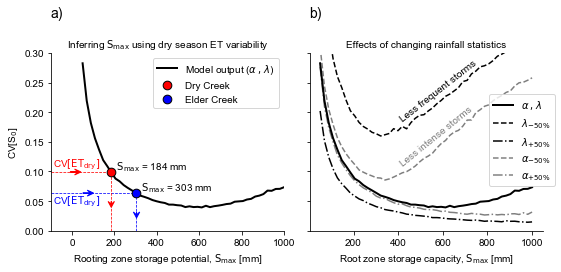

In [10]:
plotranges = False

# Get CV[S0] values from Monte Carlo sims
fn = '../data/cvs_dry_elder_50_1000_50.npy'
cvs = np.load(fn)
smaxupper = int(fn.split('.')[-2].split('_')[-2])
smaxlower = int(fn.split('.')[-2].split('_')[-3])
dS = int(fn.split('.')[-2].split('_')[-1])
Smax = np.linspace(smaxlower, smaxupper, dS)

# Grab CV[ETdry] for Elder and Dry Creek
drymax= etcvs['Dry Creek']
eldermax = etcvs['Elder Creek']

# Find Smax value where CV[ETdry] intersects theoretical curve
idx = np.where(np.diff((cvs-drymax)>0)==1)[0][0]
cvleft = cvs[idx]
cvright = cvs[idx+1]
frac = (drymax - cvleft)/(cvright - cvleft)
drymax_storage = Smax[idx] + frac*(Smax[idx+1] - Smax[idx])

idx = np.where(np.diff((cvs-eldermax)>0)==1)[0][0]
cvleft = cvs[idx]
cvright = cvs[idx+1]
frac = (eldermax - cvleft)/(cvright - cvleft)
eldermax_storage = Smax[idx] + frac*(Smax[idx+1] - Smax[idx])

# Plot it up!
f,axs = plt.subplots(1,2,figsize=(8.,4.),sharey=True)
ax = axs[0]

# Plot theoretical curve
line1, = ax.plot(Smax,cvs, 'k', lw=2.0)
label1=r'Model output ($\alpha\,,\,\lambda$)'

# Dry Creek intersection with model curve
line2 = ax.scatter(drymax_storage, drymax, c='r', s=75, zorder=10,  edgecolors='k')
label2 = 'Dry Creek'

# Elder Creek intersection with model curve
line3 = ax.scatter(eldermax_storage, eldermax, c='b', s=75, zorder=10,edgecolors='k')
label3 = 'Elder Creek'

ax.plot([-100,eldermax_storage], [eldermax, eldermax],'--', c='b', lw=0.75)
ax.plot([eldermax_storage,eldermax_storage], [0, eldermax],'--', c='b', lw=0.75)
ax.plot([-100,drymax_storage], [drymax, drymax],'--', c='r', lw=0.75)
ax.plot([drymax_storage,drymax_storage], [0, drymax],'--', c='r', lw=0.75)
# ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$ = ' + '%.2f'%(drymax), (-90, drymax+.008))
# ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$ = ' + '%.2f'%(eldermax), (-90, eldermax+.008))

ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$', (-90, drymax+.01),c='r')
ax.annotate('CV$[\mathrm{ET}_\mathrm{dry}]$', (-90, eldermax-.018),c='b')
ax.text(eldermax_storage, eldermax+.005,'  $\mathrm{S_{max}}$ = ' + '%.0f mm'%(eldermax_storage))
ax.text(drymax_storage, drymax+.005,'  $\mathrm{S_{max}}$ = ' + '%.0f mm'%(drymax_storage))
ax.set_xlabel('Rooting zone storage potential, $\mathrm{S_{max}}$ [mm]')
ax.set_ylabel('CV[S$_0$]')
titlestr = 'Inferring $\mathrm{S_{max}}$ using dry season ET variability'
ax.set_title(titlestr, fontsize=10)
ax.set_ylim([0,0.3])
ax.set_xlim([-100,1000])

# If you want to plot observed ranges for Smax on the plot
if plotranges:
    line4, = ax.plot([150, 200], [0.001,0.001], c='r', lw=6, )
    label4 = 'Observed range $\mathrm{S_{max}}$'
    line5, = ax.plot([320, 430], [0.001,0.001], c='b', lw=6,)
    label5 = 'Observed range $\mathrm{S_{max}}$'
    ax.legend([line1, line2, line4, line3, line5], [label1, label2, label4, label3, label5])
else: # otherwise just show the inversion step
    ax.legend([line1, line2,  line3, ], [label1, label2,  label3, ])

# inversion arrows
ax.arrow(drymax_storage-drymax_storage/2-100,drymax,50 ,0, length_includes_head=True,head_width=0.01, head_length=30, ec='r',fc='r', overhang=0.5)
ax.arrow(eldermax_storage-eldermax_storage/2-100,eldermax,50 ,0, length_includes_head=True,head_width=0.01, head_length=30, ec='b',fc='b', overhang=0.5)
ax.arrow(drymax_storage+1, drymax/2.0, 0, -0.01,length_includes_head=True,head_width=30, head_length=0.01, ec='r',fc='r', overhang=0.5)
ax.arrow(eldermax_storage+1, eldermax/2.0, 0, -0.01,length_includes_head=True,head_width=30, head_length=0.01, ec='b',fc='b', overhang=0.5)
ax.text(0,1.2,'a)',transform=ax.transAxes,fontsize=14)

ax = axs[1]
# SETUP PARAMETERS
num_sims = 10000
dt = 0.1
smaxlower = 50
smaxupper = 1000
numS = 50
Smax = np.linspace(smaxlower, smaxupper, numS)
cvlamminus = np.load('../data/lam-.npy')
cvlamplus = np.load('../data/lam+.npy')
cvalphaminus = np.load('../data/alpha-.npy')
cvalphaplus = np.load('../data/alpha+.npy')
fn = '../data/cvs_dry_elder_50_1000_50.npy'
y = np.load(fn)
smaxupper = int(fn.split('.')[-2].split('_')[-2])
smaxlower = int(fn.split('.')[-2].split('_')[-3])
dS = int(fn.split('.')[-2].split('_')[-1])
x = np.linspace(smaxlower, smaxupper, dS)

ax.set_xlabel('Root zone storage capacity, $\mathrm{S_{max}}$ [mm]')
ax.plot(x, y,lw=2,c='k',label=r'$\alpha\,,\,\lambda$')
ax.plot(Smax, cvlamminus, label=r'$\lambda_{-50\%}$',ls='--',c='k')
ax.plot(Smax, cvlamplus, label=r'$\lambda_{+50\%}$',ls='-.',c='k')
ax.plot(Smax, cvalphaminus, label=r'$\alpha_{-50\%}$',ls='--',c='k',alpha=0.5)
ax.plot(Smax, cvalphaplus, label=r'$\alpha_{+50\%}$',ls='-.',c='k',alpha=0.5)

ax.set_ylim([0,0.3])
ax.set_title('Effects of changing rainfall statistics',fontsize=10)
ax.legend(loc=(0.77,0.25))
ax.text(0,1.2,'b)',transform=ax.transAxes,fontsize=14)

ax.text(400,0.185,'Less frequent storms', rotation=38)
ax.text(400,0.11,'Less intense storms', rotation=39,alpha=0.5)
# ax.text(500,0.035,'More intense storms', rotation=-4,alpha=0.5)
# ax.text(280,0.005,'More frequent storms', rotation=-6)

f.tight_layout()
sns.despine()
plt.savefig('../plots/cv_end_mc_elderppt_ETdryseason.pdf')
plt.savefig('../plots/cv_end_mc_elderppt_ETdryseason.png',dpi=300)

Whole: slope = -0.02, p-value = 0.10
Whole: slope = 0.00, p-value = 0.81


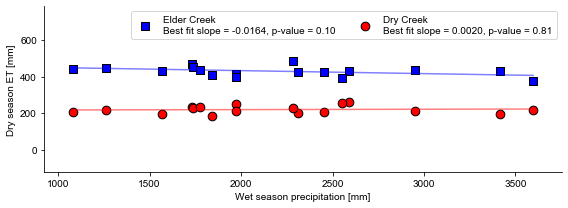

In [11]:
startyear = ppt.index[0].year
f, ax = plt.subplots(1, figsize=(8,3),sharey=True)

ppt_resolve = prism_ppt[('ppt', 'Elder Creek')]
for j,catchment in enumerate(['Elder Creek', 'Dry Creek']):
    dryets = []
    totalP = []
    yearlist = []
    for g in dry_ets.groupby(dry_ets.index):
        drydf = g[1]
        year = g[0]
        if year not in ppt_resolve.index.year.unique()[1:]:
            continue
        wetstart = pd.to_datetime(str(year-1) + '-10-01') 
        wetend = pd.to_datetime(str(year) + '-06-01') 
        yearlist.append(year)
        pptyear = ppt_resolve.loc[(ppt_resolve.index>=wetstart)&(ppt_resolve.index<=wetend)]
        totalP.append(pptyear.sum())
        dryets.append(drydf[catchment].sum())    

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(totalP,dryets)
    print('Whole: slope = %.2f, p-value = %.2f'%(slope, p_value))
    if catchment=='Dry Creek': 
        c='r' 
        ms='o'
    else: 
        c='b'
        ms='s'
    x,y = totalP, dryets
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    label = catchment + '\n'
    label = label + 'Best fit slope = %.4f, p-value = %.2f'%(slope,p_value)
    ax.scatter(x, y,c=c,edgecolors='k',s=75,label=label,alpha=1,marker=ms)
    x = np.sort(np.array(x))
    ax.plot(x,x*slope + intercept,c=c,alpha=0.5)
    
ax.legend(ncol=2)
ax.set_xlabel('Wet season precipitation [mm]')
ax.set_ylabel('Dry season ET [mm]')
ax.set_xlim([0,4000])
ax.set_ylim([0,600])
ax.axis('equal')
sns.despine(fig=f)
f.tight_layout()
f.savefig('../plots/resolve_inversion.pdf')
f.savefig('../plots/resolve_inversion.png',dpi=300)

Running 30 simulations for 3 parameter sets across 4 cores


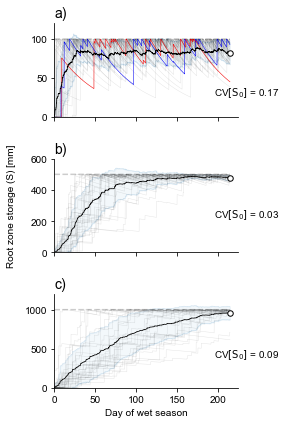

In [15]:
## try some wet season simulations against theory
Smax = [100, 500, 1000]
dt = 0.1
t = np.linspace(0,tw,int(np.ceil(tw/dt)))
num_sims = 30
args = [(lam, Smax[i], alpha, dt, tw, pet, num_sims) for i in range(len(Smax))]

# GET CORES AND RUN MODEL
num_cores = mp.cpu_count()
print('Running %d simulations for %d parameter sets across %d cores'%(num_sims,len(args),num_cores ))
pool = mp.Pool(processes=num_cores)
wet_seasons = pool.map(run_chunk_wetseason, (arg for arg in args))
CV = [np.std(item[:,-1])/np.mean(item[:,-1]) for item in wet_seasons]


fig, axs = plt.subplots(len(Smax), 1, figsize=(4, 2*len(Smax))) 
for i in range(len(axs)):
    X = wet_seasons[i]
    ax = axs[i]
    endS0 = np.mean(X,axis=0)[-1]
    ax.plot(t, np.mean(X,axis=0), label='Mean',zorder=10, c='k', lw=0.75)
    std = np.std(X, axis=0)
    upper = np.mean(X,axis=0) + std   
    lower = np.mean(X,axis=0) - std   
    ax.plot(t, upper, c='C0', lw=0.5, alpha=0.2)
    ax.plot(t, lower, c='C0', lw=0.5, alpha=0.2)
    ax.fill_between(t, lower, upper, color='C0', alpha=0.05)
    
    ax.plot(t,np.transpose(X),'k',lw=0.5, alpha=0.1, label='MC sims')
    
    if i==0: #find low/high S0 traces
        idxlow = np.where(X[:,-1]<0.7*Smax[i])[0][0]
        idxhigh = np.where(X[:,-1]>0.9*Smax[i])[0][0]
        lowtrace = X[idxlow,:]
        hightrace = X[idxhigh,:]
        ax.plot(t,lowtrace,c='r',lw=0.5)
        ax.plot(t,hightrace,c='b',lw=0.5)
        
    if ax==axs[-1]:
        ax.set_xlabel('Day of wet season')
    if ax!=axs[-1]:
        labs = ax.get_xticklabels()
        labs = ['' for i in range(len(labs))]
        ax.set_xticklabels(labs)
    S0max = np.ones_like(t)*Smax[i]
    ax.plot(t, S0max, '--k', alpha=0.2)
    cv = np.std(X[:,-1])/np.mean(X[:,-1])
    ax.text(tw-20,endS0-std[-1]-int(endS0/2), r'CV$[\mathrm{S_{0}}]$ = ' + '%.2f'%cv)
    ax.scatter(tw,endS0, c='w',s=30, edgecolor='k', zorder=100)
    ax.set_ylim([0,Smax[i]+0.2*Smax[i]])
    ax.set_xlim([0,tw+10])
    sns.despine(ax=ax)
    
axs[1].set_ylabel('Root zone storage (S) [mm]\n')

axs[0].set_title('a)',loc='left',fontsize=14)
axs[1].set_title('b)',loc='left',fontsize=14)
axs[2].set_title('c)',loc='left',fontsize=14)

fig.tight_layout()
fig.savefig('../plots/goldilocks.pdf')